In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math

In [49]:
# 1. Generate synthetic DNS dataset
def generate_dns_data(n_samples=1000, anomaly_ratio=0.05):
    """Generate synthetic DNS traffic data with normal and anomalous patterns"""
    n_anomalies = int(n_samples * anomaly_ratio)
    n_normal = n_samples - n_anomalies
    
    # Normal traffic features
    normal_data = {
        'timestamp': np.random.randint(1609459200, 1609545600, n_normal),
        'src_ip': [f"192.168.1.{np.random.randint(1, 50)}" for _ in range(n_normal)],
        'dst_ip': ["8.8.8.8"] * n_normal,
        'query': [f"example{np.random.randint(1, 20)}.com" for _ in range(n_normal)],
        'query_volume': np.random.poisson(lam=10, size=n_normal),
        'avg_ttl': np.random.normal(loc=300, scale=50, size=n_normal),
        'min_ttl': np.random.normal(loc=250, scale=40, size=n_normal),
        'max_ttl': np.random.normal(loc=350, scale=60, size=n_normal),
        'tx_id': np.random.randint(0, 65535, n_normal),
        'pkt_size': np.random.normal(500, 100, n_normal),
        'tx_id_entropy': np.random.normal(loc=7.5, scale=0.5, size=n_normal),
        'label': 0
    }
    
    # Anomalous traffic features (cache poisoning patterns)
    anomaly_data = {
        'timestamp': np.random.randint(1609459200, 1609545600, n_anomalies),
        'src_ip': [f"10.0.0.{np.random.randint(1, 5)}" for _ in range(n_anomalies)],
        'dst_ip': ["8.8.8.8"] * n_anomalies,
        'query': [f"malicious{np.random.randint(1, 5)}.com" for _ in range(n_anomalies)],
        'query_volume': np.random.poisson(lam=50, size=n_anomalies),
        'avg_ttl': np.random.normal(loc=5, scale=2, size=n_anomalies),
        'min_ttl': np.random.normal(loc=1, scale=1, size=n_anomalies),
        'max_ttl': np.random.normal(loc=10, scale=3, size=n_anomalies),
        'tx_id': np.random.randint(0, 255, n_anomalies),  # Low entropy TX IDs
        'pkt_size': np.random.normal(800, 200, n_anomalies),
        'tx_id_entropy': np.random.normal(loc=2.0, scale=0.2, size=n_anomalies),
        'label': 1
    }
    
    # Combine into DataFrame
    df_normal = pd.DataFrame(normal_data)
    df_anomalies = pd.DataFrame(anomaly_data)
    df = pd.concat([df_normal, df_anomalies], ignore_index=True)
    
    # Shuffle the dataset
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

In [50]:
# 2. Feature engineering
def create_features(df):
    """Create aggregate features from raw DNS data"""
    # Calculate additional features
    df['ttl_variation'] = df['max_ttl'] - df['min_ttl']
    df['query_length'] = df['query'].str.len()
    
    # Select final features for modeling
    features = [
        'query_volume',
        'avg_ttl',
        'ttl_variation',
        'tx_id_entropy',
        'pkt_size',
        'query_length'
    ]
    
    return df[features + ['label']]


In [51]:
# 3. Train and evaluate model
def train_and_evaluate(df):
    """Train Isolation Forest model and evaluate performance"""
    X = df.drop('label', axis=1)
    y = df['label']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = IsolationForest(
        n_estimators=100,
        contamination=0.05,
        random_state=42,
        verbose=1
    )
    model.fit(X_train_scaled)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred = np.where(y_pred == -1, 1, 0)  # Convert to 0/1 labels
    
    # Evaluate
    print("\nModel Evaluation:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    return model, scaler

In [52]:
# 4. Visualize results
def visualize_results(df, features):
    """Plot feature distributions and anomaly detection results"""
    # Feature distributions
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 3, i)
        sns.histplot(
            data=df, 
            x=feature, 
            hue='label', 
            element='step', 
            kde=True,
            common_norm=False
        )
        plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()
    
    # Anomaly scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='avg_ttl', 
        y='tx_id_entropy', 
        hue='label', 
        data=df, 
        palette={0: 'blue', 1: 'red'}
    )
    plt.title('DNS Anomaly Patterns')
    plt.xlabel('Average TTL')
    plt.ylabel('TX ID Entropy')
    plt.grid(True)
    plt.show()


DNS Cache Poisoning Anomaly Detector

Generating synthetic DNS dataset...
Dataset sample:
    timestamp        src_ip   dst_ip           query  query_volume  \
0  1609541792      10.0.0.2  8.8.8.8  malicious2.com            61   
1  1609528468  192.168.1.37  8.8.8.8    example4.com            13   
2  1609523727  192.168.1.43  8.8.8.8    example9.com            13   
3  1609530289  192.168.1.38  8.8.8.8    example8.com            13   
4  1609482449  192.168.1.10  8.8.8.8   example17.com            11   

      avg_ttl     min_ttl     max_ttl  tx_id    pkt_size  tx_id_entropy  label  
0    7.707241    0.913139    9.345569    219  571.549116       1.993126      1  
1  247.291204  290.255178  414.677103  53768  445.285690       7.388375      0  
2  273.613529  219.250029  359.552142  56482  502.515253       7.185115      0  
3  300.120211  230.107486  338.863237  43490  620.267619       9.045610      0  
4  325.068779  234.229354  385.954070   9379  475.949857       7.145321      0  

Cr

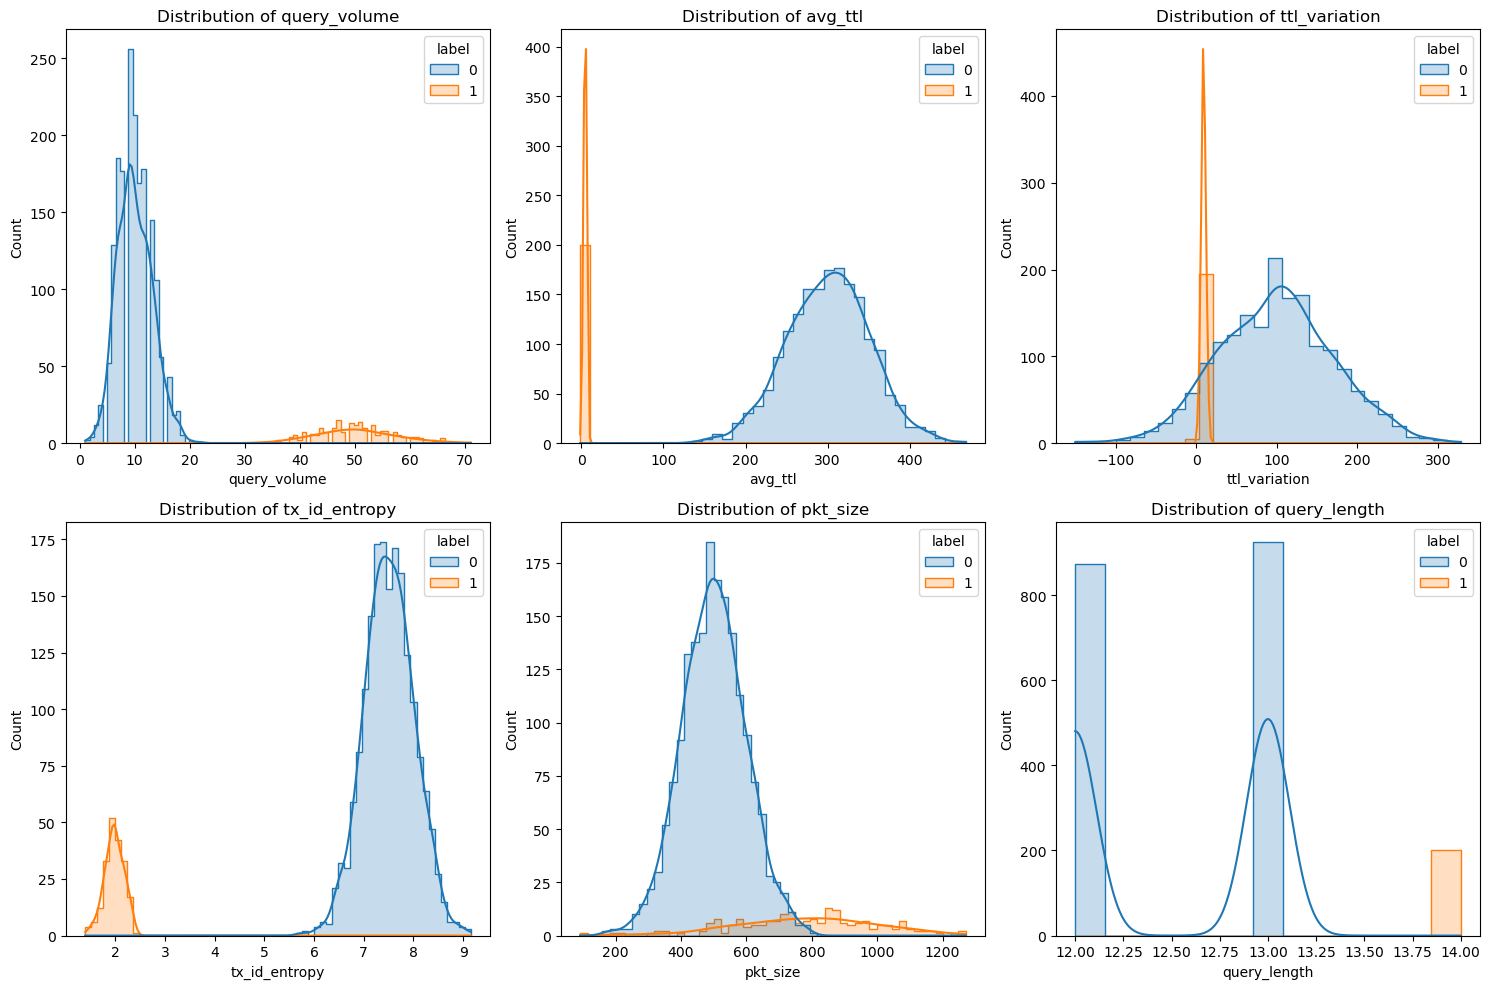

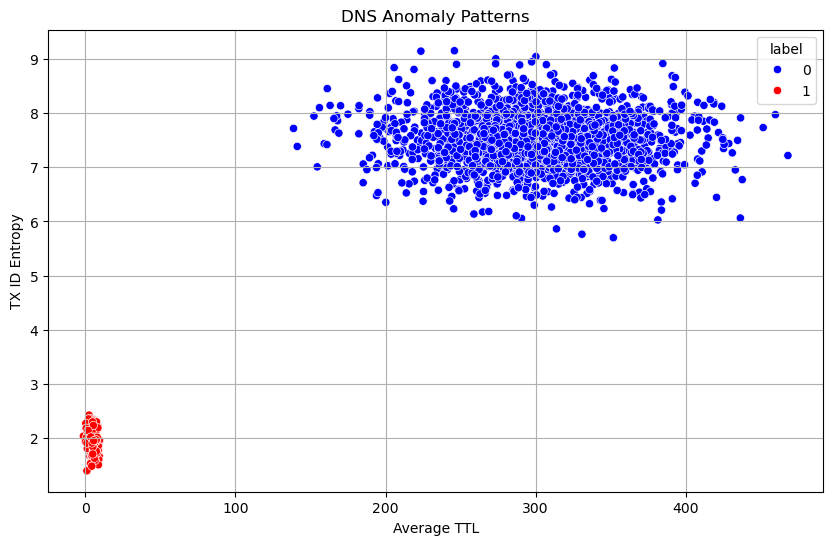


Training anomaly detection model...

Model Evaluation:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       536
           1       0.94      0.52      0.67        64

    accuracy                           0.94       600
   macro avg       0.94      0.76      0.82       600
weighted avg       0.94      0.94      0.94       600


Confusion Matrix:
[[534   2]
 [ 31  33]]

Model training complete!


In [53]:
# Main execution
if __name__ == "__main__":
    print("DNS Cache Poisoning Anomaly Detector")
    
    # 1. Generate synthetic dataset
    print("\nGenerating synthetic DNS dataset...")
    dns_data = generate_dns_data(n_samples=2000, anomaly_ratio=0.1)
    print("Dataset sample:")
    print(dns_data.head())
    
    # 2. Create features
    print("\nCreating features...")
    features_df = create_features(dns_data)
    print("Features used for modeling:")
    print(features_df.head())
    
    # 3. Visualize data
    print("\nVisualizing feature distributions...")
    visualize_results(features_df, features_df.columns[:-1])  # Exclude label column
    
    # 4. Train and evaluate model
    print("\nTraining anomaly detection model...")
    model, scaler = train_and_evaluate(features_df)
    print("\nModel training complete!")